<a href="https://colab.research.google.com/github/ANIZAI/Generation-of-Audio-Description-of-Images/blob/main/successfull_captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

In [ ]:
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

252878848/252872794 [==============================] - 4s 0us/step


In [ ]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

In [ ]:
for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    all_captions.append(caption)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

In [ ]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)
all_seqs = tokenizer.texts_to_sequences(all_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
all_seqs = tokenizer.texts_to_sequences(all_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(all_seqs, padding='post')

In [ ]:
#max_length = calc_max_length(all_seqs)
max_length = 52

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
features_shape = 2048
attention_features_shape = 64

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights



In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

 

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

    

    

In [ ]:
def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

In [ ]:
 def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
def evaluate(image, encoder1, decoder1):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder1.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder1(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer1.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder1(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer1.index_word[predicted_id])

        if tokenizer1.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
test_tensor_img = tf.convert_to_tensor(np.ones((64, 64, 2048)))
target = tf.convert_to_tensor(np.ones((64, 49)))

In [ ]:
!cp -r /content/drive/My\ Drive/tokenizer.pickle .

In [ ]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

In [ ]:
!cp -r /content/drive/My\ Drive/encoder.h5 .
!cp -r /content/drive/My\ Drive//decoder.h5 .

In [ ]:
encoder1 = CNN_Encoder(embedding_dim)
encoder1(test_tensor_img)
encoder1.load_weights('./encoder.h5')
decoder1 = RNN_Decoder(embedding_dim, units, vocab_size)
hidden = decoder1.reset_state(batch_size=test_tensor_img.shape[0])
dec_input = tf.expand_dims([tokenizer1.word_index['<start>']] * target.shape[0], 1)
features = encoder1(test_tensor_img)
decoder1(dec_input, features, hidden)
decoder1.load_weights('./decoder.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
max_length

52

In [ ]:
image_url = 'https://images.template.net/wp-content/uploads/2016/04/27043339/Nature-Wallpaper1.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

90112/83751 [================================] - 0s 0us/step


Caption: some animals by a hill and trees <end>


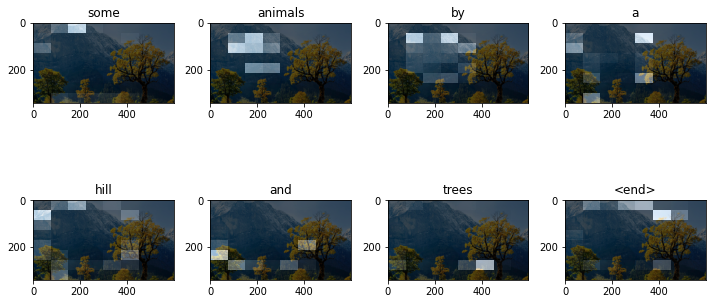

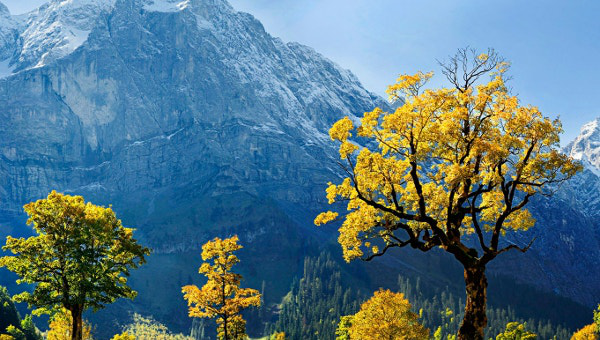

In [ ]:
result, attention_plot = evaluate(image_path, encoder1, decoder1)
print ('Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
pip install gTTS

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=0503dad16c6c82742ba377653bc877f45b5e8e1f7520fba4b444d60aa03a3638
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token


In [ ]:
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 
  
# This module is imported so that we can  
# play the converted audio 
import os 
  
# The text that you want to convert to audio 
mytext = str(result)
removeSpecialChars = mytext.translate({ord(c):" " for c in "~!@#$%^&*()_+=-`[]{}\|',./?<>"})
# Language in which you want to convert 
language = 'en'
  
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
myobj = gTTS(text=removeSpecialChars, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("caption.mp3") 
  
# Playing the converted file 
os.system("mpg321 caption.mp3") 

32512